In [1]:
# Dependencies and configuration
import os
from src.config import settings

os.makedirs(settings.panels_dir, exist_ok=True)
os.makedirs(settings.crops_dir, exist_ok=True)

In [3]:
from modules.coreMPE.src.adenzu_panel.image_processing import panel

_ = panel.extract_panels_for_images_in_folder_recursive(
    input_dir=str(settings.pages_dir),
    output_dir=str(settings.panels_dir),
    split_joint_panels=False,   # maps to --split-joint-panels
    fallback=True              # maps to --fallback
)

Extracting panels: 100%|██████████| 284/284 [03:47<00:00,  1.25it/s]


In [4]:
# Extract head crops (YOLOv8_animeface)
from src.headExtraction import anime_extraction_recursive

valid_exts = {".jpg", ".jpeg", ".png"}
panel_paths = sorted(
    [p for p in settings.panels_dir.iterdir() if p.suffix.lower() in valid_exts]
)
num_crops = anime_extraction_recursive()

print(f"Extracted {num_crops} faces")

Detecting faces in panels: 100%|██████████| 1127/1127 [17:03<00:00,  1.10it/s]

Saved 1663 anime face crops to data/crops
Extracted 1663 faces


Found 20654 crops under data/crops


Loading crops: 100%|██████████| 20654/20654 [00:24<00:00, 835.10it/s]


Successfully loaded 20654 crops
323/323 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step
Generated embeddings of shape (20654, 256)
Saved embeddings to data/embeddings.npy
Saved crop paths to data/crop_paths.json
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


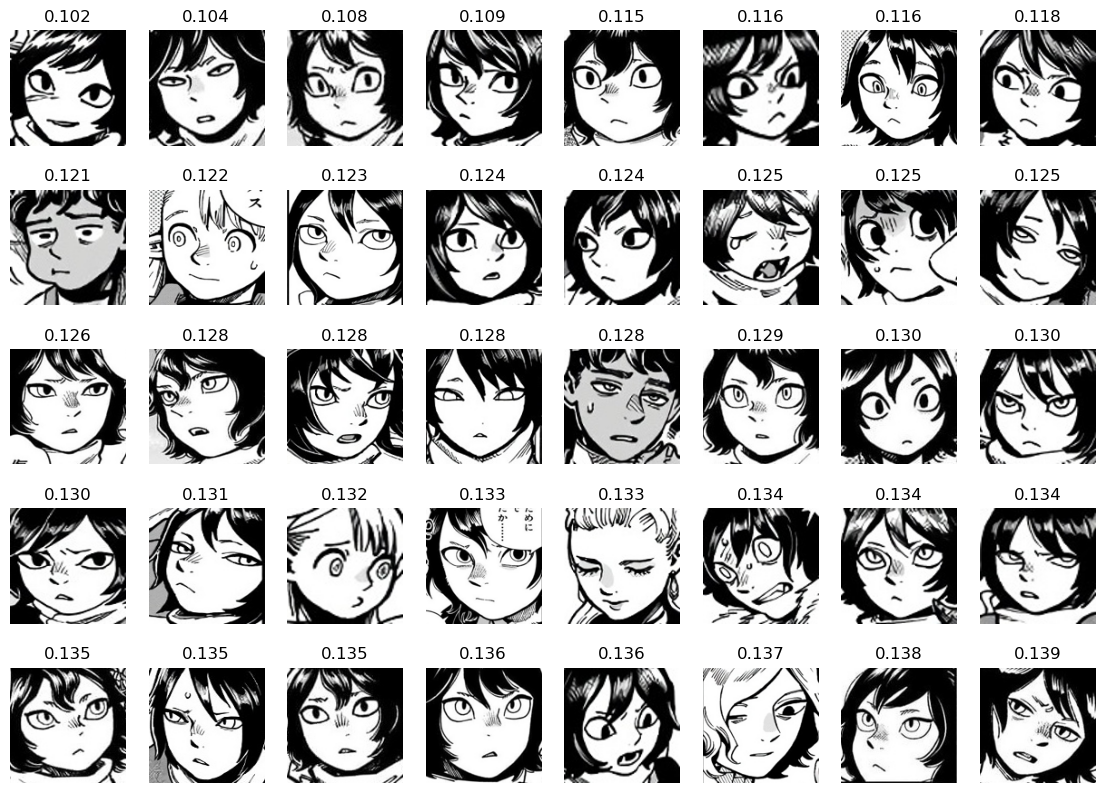

In [5]:
# Nearest neighbor algorithm for Izutsumi recognition
from src.recognitionModel import build_model, char_nearest_neighbor, build_model_stream

IMG_SIZE = 128

embed_model = build_model_stream(IMG_SIZE, settings.crops_dir)
seed_paths = [str(p) for p in sorted(settings.izutsumi_dir.glob("*.jpg"))] # Seeds

char_nearest_neighbor(settings.embed_path, settings.crop_path, IMG_SIZE, embed_model, seed_paths)